In [1]:
import subprocess
import os
import copy

import semantic as s
import semantic_rule_set
import syntactic_and_semantic_rules

import en

In [2]:
#setup
training_sentences_file = 'training.txt'
testing_sentences_file = 'testing.txt'
show_database = False
validate = False
gui = False

with open(training_sentences_file, 'r') as f:
    training_sentences = [x.strip() for x in f]
with open(testing_sentences_file, 'r') as f:
    testing_sentences = [x.strip() for x in f]

sem = semantic_rule_set.SemanticRuleSet()
sem = syntactic_and_semantic_rules.addLexicon(sem)

### Predicting the missing word

Our goal is take a sentence with a missing word -- 
 for example "Mary ate a \_", and replace the blank with a 'reasonable' replacement word.
This task is something that people do everyday, especially in a noisy setting or when speaking to someone with a thick accent. 
However, this task goes beyond just syntactic validity, since few people would guess that the sentence was 'Mary ate a laptop'. We need to inject some notion of semantics. However, we cannot just naively apply methods from WordNet, because we are missing the word that fits in the blank. Most WordNet methods are ways of mapping from one word to other words that are related in a particular way, eg hypernymy or synonymy. 

So in order to move forward, we should first come up with a way of distinguishing valid sentences in a way that lets us generate a missing word. We decided to adopt a model of language learning that is very similar to the notion of near-miss learning. We take a set of training sentences, use software from lab 3 to convert them into event structures, and group event structures together in a way that lets us generalize semantically valid sentences from our training data. This means that we are assuming that the training data is semantically valid. 

Below, we will experiment with different grouping and generalization strategies in order to determine semantically valid replacements for a missing word.

### Generate Event Structures
First we generate event structures from sentences, which we store in a list of dictionaries for simplicity.

In [3]:
print training_sentences
events = map(lambda sent: s.sentenceToEventDict(sem, sent), training_sentences)
for e in events:
    print e

['John ate the potato', 'John ate the tomato', 'Mary ate the tomato']
{'action': 'eat', 'patient': 'potato', 'tense': 'past', 'agent': 'John'}
{'action': 'eat', 'patient': 'tomato', 'tense': 'past', 'agent': 'John'}
{'action': 'eat', 'patient': 'tomato', 'tense': 'past', 'agent': 'Mary'}


### Simplest Strategy: No Grouping

In [4]:
#Parse each sentence in training data
def train(sem, sentences, groupEvents):
    event_list = []
    for sentence in sentences:
        try:
           new_event_dict = s.sentenceToEventDict(sem, sentence)
           event_list = groupEvents(event_list, new_event_dict)
        except Exception as e:
            # The parser did not return any parse trees.
            raise
    return event_list

def keepSeparate(event_list, new_event_dict):
    return event_list + [new_event_dict]

event_groupings = train(sem, training_sentences, keepSeparate)
for g in event_groupings:
    print g

{'action': 'eat', 'patient': 'potato', 'tense': 'past', 'agent': 'John'}
{'action': 'eat', 'patient': 'tomato', 'tense': 'past', 'agent': 'John'}
{'action': 'eat', 'patient': 'tomato', 'tense': 'past', 'agent': 'Mary'}


### One Difference Groupings
This is a very conservative form of grouping. If two training sentences the same event structure but differ across one feature, we group together the values of that feature.

In [5]:
def groupIfOneDiff(event_list, new_event): #if different structure, do not match
    #maybe only do after reaching a certain size
    new_event_list = copy.deepcopy(event_list)
    merged = False
    #try merging in
    for i in range(len(event_list)): #try to match with event_list[i]
        event = event_list[i]
        if set(event.keys()) == set(new_event.keys()):
            unequal_count = 0
            for feat in event.keys():
                if new_event[feat] not in event[feat]:
                    unequal_feat = feat
                    unequal_count += 1
            if unequal_count == 0: merged = True
            elif unequal_count == 1: #merge into previous
                new_event_list[i][unequal_feat].add(new_event[unequal_feat])
                merged = True
    #make new spot
    if not merged:
        new_event_list.append({k:set([v]) for k,v in new_event.iteritems()})
    return new_event_list

event_groupings = train(sem, training_sentences, groupIfOneDiff)
for e in events:
    print e
for g in event_groupings:
    print g

{'action': 'eat', 'patient': 'potato', 'tense': 'past', 'agent': 'John'}
{'action': 'eat', 'patient': 'tomato', 'tense': 'past', 'agent': 'John'}
{'action': 'eat', 'patient': 'tomato', 'tense': 'past', 'agent': 'Mary'}
{'action': set(['eat']), 'tense': set(['past']), 'patient': set(['tomato', 'potato']), 'agent': set(['John', 'Mary'])}


Note that the above only produces one output grouping (as opposed to two groupings, composed of sentences (1,2) and (2,3)).
This is because we are applying the groupings iteratively. We loop through the events, and compare the current event with the groupings that we have collected up to that point. The comparison in this case is not checking for equality between values of a common feature, but rather it is checking for inclusion of the current event's feature values within groupings of that feature.
```python
for feat in event.keys():
    if new_event[feat] not in event[feat]:
        unequal_feat = feat
```
This part of the previous method demonstrates this inclusion checking.

This implies that the same training sentences, in different orders, can lead to different event groupings.

In [6]:
def rotate(lst): 
    return [lst[-1]] + lst[:-1]
print training_sentences
print training_sentences[::-1]
event_groupings_1 = train(sem, training_sentences, groupIfOneDiff)
event_groupings_2 = train(sem, rotate(training_sentences), groupIfOneDiff)

print event_groupings_1 #creates 1 group
print event_groupings_2 #creates 2 groups

['John ate the potato', 'John ate the tomato', 'Mary ate the tomato']
['Mary ate the tomato', 'John ate the tomato', 'John ate the potato']
[{'action': set(['eat']), 'tense': set(['past']), 'patient': set(['tomato', 'potato']), 'agent': set(['John', 'Mary'])}]
[{'action': set(['eat']), 'tense': set(['past']), 'patient': set(['tomato']), 'agent': set(['John', 'Mary'])}, {'action': set(['eat']), 'patient': set(['tomato', 'potato']), 'tense': set(['past']), 'agent': set(['John'])}]


This grouping pattern is related to near-miss learning:

The reason that event_groupings_2 creates 2 instead of 1 grouping is that the 1st and 2nd sentence differ from each other is 2 ways, instead of just 1.
    
But maybe this is a bit too conservative of an assumption. Alternately we could try grouping when seeing two differences.

In [7]:
def groupIfOneOrTwoDiffs(event_list, new_event): #if different structure, do not match
    #maybe only do after reaching a certain size
    new_event_list = copy.deepcopy(event_list)
    merged = False
    #try merging in
    for i in range(len(event_list)): #try to match with event_list[i]
        event = event_list[i]
        if set(event.keys()) == set(new_event.keys()):
            unequal_count = 0
            for feat in event.keys():
                if new_event[feat] not in event[feat]:
                    if unequal_count == 0:
                        unequal_feat_1 = feat
                    if unequal_count == 1:
                        unequal_feat_2 = feat
                    unequal_count += 1
            if unequal_count == 0: merged = True
            elif unequal_count == 1: #merge into previous
                new_event_list[i][unequal_feat_1].add(new_event[unequal_feat_1])
                merged = True
            elif unequal_count == 2: #merge into previous
                new_event_list[i][unequal_feat_1].add(new_event[unequal_feat_1])
                new_event_list[i][unequal_feat_2].add(new_event[unequal_feat_2])
                merged = True
    #make new spot
    if not merged:
        new_event_list.append({k:set([v]) for k,v in new_event.iteritems()})
    return new_event_list

events = map(lambda sent: s.sentenceToEventDict(sem, sent), rotate(training_sentences))
for e in events:
    print e
event_groupings = train(sem, rotate(training_sentences), groupIfOneOrTwoDiffs)
print event_groupings

{'action': 'eat', 'patient': 'tomato', 'tense': 'past', 'agent': 'Mary'}
{'action': 'eat', 'patient': 'potato', 'tense': 'past', 'agent': 'John'}
{'action': 'eat', 'patient': 'tomato', 'tense': 'past', 'agent': 'John'}
[{'action': set(['eat']), 'tense': set(['past']), 'patient': set(['tomato', 'potato']), 'agent': set(['John', 'Mary'])}]


### Filling In the Word Blank
Now that we have come up with some event grouping strategies, we return to the original goal of our project -- to fill in the missing word.

The reason for the groupings above, is that we would like to take training event structures like:
```python
['John ate the potato', 'John ate the tomato', 'Mary ate the tomato']
```
And conclude that:
```python
['Mary ate the potato']
```
is a valid sentence.

In [13]:
def checkGoodSentence(sem, sentence, event_groupings):
    event = s.sentenceToEventDict(sem, sentence)
    if not event: return False
    for event_group in event_groupings:
        if set(event.keys()) == set(event_group.keys()):
            if all([event[k] in event_group[k] for k in event.keys()]):
                return True
    return False

sentence = 'Mary ate the potato'
event_groupings = train(sem, training_sentences, groupIfOneDiff)
event = s.sentenceToEventDict(sem, sentence)
print event
print event_groupings

print checkGoodSentence(sem, sentence, event_groupings)

{'action': 'eat', 'patient': 'potato', 'tense': 'past', 'agent': 'Mary'}
[{'action': set(['eat']), 'tense': set(['past']), 'patient': set(['tomato', 'potato']), 'agent': set(['John', 'Mary'])}]
True


What the above means is that the grouping structure that we have generated 'accepts' the sentence 'Mary ate the potato' after being trained on the 3 sentences above, which is exactly what we were looking for!

However, we want to be able to hypothesize that 'potato' is a good word to fill in for 'Mary ate the \_'. So instead of starting with 'Mary ate the potato', let's start with 'Mary ate the \_', and check the semantic validity of every word in the lexicon.

In [14]:
def gapSentenceToFillerWordGuesses(sem, gap_sentence, event_groupings):
    good_hypotheses = []
    guess_words = s.getTerminals(sem) #all words in the lexicon
    filler_i = gap_sentence.index('_')
        
    try:
        for guess_word in guess_words:
            guess_sentence = gap_sentence.replace('_',guess_word)
            if checkGoodSentence(sem, guess_sentence, event_groupings):
                good_hypotheses.append(guess_word)
    except: pass
    return good_hypotheses

filler_word_guesses = gapSentenceToFillerWordGuesses(sem, 'Mary ate the _', event_groupings)
print filler_word_guesses

['potato', 'tomato']


This is doing what we want, but ideally we would like to extend our groupings to more than just the lexicon that we have written down.

This is where we can use wordnet to generalize our results.

In [16]:
from nltk.corpus import wordnet as wn

def flatten(lst):
    out = []
    for x in lst:
        if type(x) is list:
            out.extend(flatten(x))
        else:
            out.append(x)
    return out

gap_sentence = 'Mary ate the _'
what_mary_ate = gapSentenceToFillerWordGuesses(sem, gap_sentence, event_groupings)
synonyms = flatten(map(lambda w: map(lambda x: x.lemma_names(), wn.synsets(w)), what_mary_ate))

sents = ['Mary ate the '+syn for syn in synonyms]
for x in sents: print x

Mary ate the potato
Mary ate the white_potato
Mary ate the Irish_potato
Mary ate the murphy
Mary ate the spud
Mary ate the tater
Mary ate the potato
Mary ate the white_potato
Mary ate the white_potato_vine
Mary ate the Solanum_tuberosum
Mary ate the tomato
Mary ate the tomato
Mary ate the love_apple
Mary ate the tomato_plant
Mary ate the Lycopersicon_esculentum


We immediately see a problem with this method. In trying to generalize our semantic results, we lose even basic syntactic correctness.
If I change the training sentences to present tense, I end up with noun synonyms.

Note that here I am filtering by noun synonym class for clarity.

Eg 'Mary _ the tomato' --> 'Mary chow the tomato'

In [17]:
gap_sentence = 'Mary _ the tomato'
what_mary_did = gapSentenceToFillerWordGuesses(sem, gap_sentence, event_groupings)
synonyms = flatten(map(lambda w: map(lambda x: x.lemma_names(), wn.synsets(w)), what_mary_did))
noun_synonyms = flatten(map(lambda w: map(lambda x: x.lemma_names(), wn.synsets(w, wn.NOUN)), what_mary_did))

for syn in synonyms:
    sentence = 'Mary '+syn+' the tomato'
    if syn in noun_synonyms:
        print "Noun synonym: "+sentence
    else:
        print "Verb synonym: "+sentence

Noun synonym: Mary Ate the tomato
Verb synonym: Mary eat the tomato
Verb synonym: Mary eat the tomato
Verb synonym: Mary feed the tomato
Verb synonym: Mary eat the tomato
Verb synonym: Mary eat the tomato
Verb synonym: Mary eat_on the tomato
Verb synonym: Mary consume the tomato
Verb synonym: Mary eat_up the tomato
Verb synonym: Mary use_up the tomato
Verb synonym: Mary eat the tomato
Verb synonym: Mary deplete the tomato
Verb synonym: Mary exhaust the tomato
Verb synonym: Mary run_through the tomato
Verb synonym: Mary wipe_out the tomato
Verb synonym: Mary corrode the tomato
Verb synonym: Mary eat the tomato
Verb synonym: Mary rust the tomato
Noun synonym: Mary Ate the tomato
Verb synonym: Mary eat the tomato
Verb synonym: Mary eat the tomato
Verb synonym: Mary feed the tomato
Verb synonym: Mary eat the tomato
Verb synonym: Mary eat the tomato
Verb synonym: Mary eat_on the tomato
Verb synonym: Mary consume the tomato
Verb synonym: Mary eat_up the tomato
Verb synonym: Mary use_up the t

However, in this case, I can just as easily filter by verb, fixing the part of speech, but not the tense or the plurality.

In [18]:
synonyms = flatten(map(lambda w: map(lambda x: x.lemma_names(), wn.synsets(w, wn.VERB)), what_mary_did))

sents = ['Mary '+syn+' the tomato' for syn in synonyms]
for x in sents: print x

Mary eat the tomato
Mary eat the tomato
Mary feed the tomato
Mary eat the tomato
Mary eat the tomato
Mary eat_on the tomato
Mary consume the tomato
Mary eat_up the tomato
Mary use_up the tomato
Mary eat the tomato
Mary deplete the tomato
Mary exhaust the tomato
Mary run_through the tomato
Mary wipe_out the tomato
Mary corrode the tomato
Mary eat the tomato
Mary rust the tomato
Mary eat the tomato
Mary eat the tomato
Mary feed the tomato
Mary eat the tomato
Mary eat the tomato
Mary eat_on the tomato
Mary consume the tomato
Mary eat_up the tomato
Mary use_up the tomato
Mary eat the tomato
Mary deplete the tomato
Mary exhaust the tomato
Mary run_through the tomato
Mary wipe_out the tomato
Mary corrode the tomato
Mary eat the tomato
Mary rust the tomato


One potential attempt at a fix would be to use an off-the-shelf parser to check the syntactic validity of each proposed sentence.

Below, we try this with the Penn Tree Bank grammar.

In [19]:
import nltk
#nltk.download('treebank')
from nltk.corpus import treebank
from nltk.grammar import CFG, Nonterminal

tbank_productions = set(production for sent in treebank.parsed_sents()
                        for production in sent.productions())
tbank_grammar = CFG(Nonterminal('S'), list(tbank_productions))
parser = nltk.parse.EarleyChartParser(tbank_grammar)
print list(parser.parse('Mary has food'.split()))

[Tree('S', [Tree('NP-SBJ-8', [Tree('NNP', ['Mary'])]), Tree('VP', [Tree('VBP', ['has']), Tree('NP-TMP-CLR', [Tree('NN', ['food'])])])]), Tree('S', [Tree('NP-SBJ-8', [Tree('NNP', ['Mary'])]), Tree('VP', [Tree('VP', [Tree('VBP', ['has']), Tree('NP-TMP-CLR', [Tree('NN', ['food'])])])])]), Tree('S', [Tree('NP-SBJ-8', [Tree('NNP', ['Mary'])]), Tree('VP', [Tree('VP', [Tree('VBZ', ['has']), Tree('NP-PRD', [Tree('NN', ['food'])])])])]), Tree('S', [Tree('NP-SBJ-8', [Tree('NNP', ['Mary'])]), Tree('VP', [Tree('VP', [Tree('VBZ', ['has']), Tree('NP-PRD', [Tree('NP', [Tree('NN', ['food'])])])])])]), Tree('S', [Tree('NP-SBJ-8', [Tree('NNP', ['Mary'])]), Tree('VP', [Tree('VP', [Tree('VBZ', ['has']), Tree('NP-PRD', [Tree('NP', [Tree('NP', [Tree('NN', ['food'])])])])])])]), Tree('S', [Tree('NP-SBJ-8', [Tree('NNP', ['Mary'])]), Tree('VP', [Tree('VP', [Tree('VBP', ['has']), Tree('NP-PRD', [Tree('NN', ['food'])])])])]), Tree('S', [Tree('NP-SBJ-8', [Tree('NNP', ['Mary'])]), Tree('VP', [Tree('VP', [Tree('VBP

Well, it looks like the above is effectively useless for our purposes.
It will only have the words in the small subset of PTB that we can download, and takes very long to parse even 'Mary has food'. 

Let's try CMU's link grammar.

In [20]:
%%bash
cd ./link-4.1b-mod/ && make -B

gcc -c -g -O -w -Iinclude src/parse.c -o obj/parse.o
gcc -c -g -O -w -Iinclude src/prune.c -o obj/prune.o
gcc -c -g -O -w -Iinclude src/and.c -o obj/and.o
gcc -c -g -O -w -Iinclude src/post-process.c -o obj/post-process.o
gcc -c -g -O -w -Iinclude src/pp_lexer.c -o obj/pp_lexer.o
gcc -c -g -O -w -Iinclude src/resources.c -o obj/resources.o
gcc -c -g -O -w -Iinclude src/analyze-linkage.c -o obj/analyze-linkage.o
gcc -c -g -O -w -Iinclude src/string-set.c -o obj/string-set.o
gcc -c -g -O -w -Iinclude src/pp_linkset.c -o obj/pp_linkset.o
gcc -c -g -O -w -Iinclude src/pp_knowledge.c -o obj/pp_knowledge.o
gcc -c -g -O -w -Iinclude src/error.c -o obj/error.o
gcc -c -g -O -w -Iinclude src/word-file.c -o obj/word-file.o
gcc -c -g -O -w -Iinclude src/utilities.c -o obj/utilities.o
gcc -c -g -O -w -Iinclude src/tokenize.c -o obj/tokenize.o
gcc -c -g -O -w -Iinclude src/command-line.c -o obj/command-line.o
gcc -c -g -O -w -Iinclude src/read-dict.c -o obj/read-dict.o
gcc -c -g -O -w -Iinclude src/

In [22]:
def filterBySyntax(sentences):
    with open("./link-4.1b-mod/input.txt", "w+") as f:
        for sentence in sentences:
            f.write(sentence+'\n')

    wd = os.getcwd()
    os.chdir(wd+"/link-4.1b-mod")
    subprocess.call(['./parse'])
    os.chdir(wd)

    with open("./link-4.1b-mod/output.txt", "r") as f:
        syntactical_sentences = [x for x in f.read().split('\n') if x != '']
    return syntactical_sentences

synonyms = flatten(map(lambda w: map(lambda x: x.lemma_names(), wn.synsets(w)), what_mary_did))
sentences = ['Mary '+syn+' the tomato' for syn in synonyms]
syntactical_sentences = filterBySyntax(sentences)
print syntactical_sentences

[]


This seems to be working better as a syntax filter, but we are again at a cross-roads. No sentence from our generalizations was grammatical!

So we will have to be a bit more careful in how we handle this.

For this particular case, we can use the NodeBox English Linguistics library to force conjugation of the proposed verbs.

In [24]:
conjs = []
for syn in synonyms:
    try:
        conj = en.verb.present(syn, person=3, negate=False)
        conjs.append(conj)
    except Exception as e:
        conjs.append('')

print synonyms[0:5]
print conjs[0:5]

[u'Ate', u'eat', u'eat', u'feed', u'eat']
['', 'eats', 'eats', 'fees', 'eats']


In [25]:
conj_sents = ['Mary '+conj+' the tomato' for conj in conjs if conj]

print "sentences with conjugated verb: "
print conj_sents
print ""

filtered = filterBySyntax(conj_sents)
print "after filter: " 
print filtered

print ""
print "removed: "
print [x for x in conj_sents if x not in filtered]

sentences with conjugated verb: 
['Mary eats the tomato', 'Mary eats the tomato', 'Mary fees the tomato', 'Mary eats the tomato', 'Mary eats the tomato', 'Mary consumes the tomato', 'Mary eats the tomato', 'Mary depletes the tomato', 'Mary exhausts the tomato', 'Mary corrodes the tomato', 'Mary eats the tomato', 'Mary rusts the tomato', 'Mary eats the tomato', 'Mary eats the tomato', 'Mary fees the tomato', 'Mary eats the tomato', 'Mary eats the tomato', 'Mary consumes the tomato', 'Mary eats the tomato', 'Mary depletes the tomato', 'Mary exhausts the tomato', 'Mary corrodes the tomato', 'Mary eats the tomato', 'Mary rusts the tomato']

after filter: 
['Mary eats the tomato', 'Mary eats the tomato', 'Mary eats the tomato', 'Mary eats the tomato', 'Mary consumes the tomato', 'Mary eats the tomato', 'Mary depletes the tomato', 'Mary exhausts the tomato', 'Mary corrodes the tomato', 'Mary eats the tomato', 'Mary eats the tomato', 'Mary eats the tomato', 'Mary eats the tomato', 'Mary eats 

This finally allows us to come up with generalized alternatives for 'Mary _  the tomato'!
The problem with the above method; however, is that we had to manually specify that the blank was supposed to be 3rd-person verb.

We need to get away from this if we would like to generalize to English in general. Ideally, we could look at the event structures that we generate from our original grouping procedure, and use that information to automate the conjugation/modification of our generated sentences.

In [26]:
#start_sentence = 'Mary _ the tomato'
#filler_word_guesses = test(sem, [start_sentence], event_groupings)
#print filler_word_guesses
#what_mary_did = filler_word_guesses['Mary _ the tomato']
what_mary_did_sentences = ['Mary '+verb+" the tomato" for verb in what_mary_did]
generated_event_structures = [s.sentenceToEventDict(sem, sentence) for sentence in what_mary_did_sentences]
print generated_event_structures[0]

{'action': 'eat', 'patient': 'tomato', 'tense': 'past', 'agent': 'Mary'}


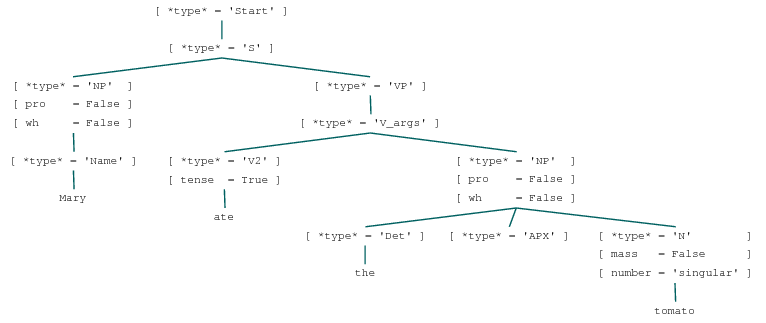

In [27]:
s.parse_input_str(sem, what_mary_did_sentences[0])

In [28]:
tree = s.parse_input_str(sem, what_mary_did_sentences[0])
print tree

(Start[]
  (S[]
    (NP[-pro, -wh] (Name[] Mary))
    (VP[]
      (V_args[]
        (V2[+tense] ate)
        (NP[-pro, -wh]
          (Det[] the)
          (APX[] )
          (N[-mass, number='singular'] tomato))))))


In [29]:
subtree = tree.pos()[1] # 2nd element of sentence was blank
print subtree

print ""
features = subtree[1]
print features
#print tree.leaf_treeposition(1)
#print tree[0][1][0][0]

('ate', V2[+tense])

[ *type* = 'V2' ]
[ tense  = True ]


In [30]:
test_sentence = 'Mary _ the tomato'
filler_index = test_sentence.split().index('_')
print synonyms, '\n'

for sentence in what_mary_did_sentences:
    tree = s.parse_input_str(sem, sentence)
    features = tree.pos()[filler_index][1]
    print features, '\n'


[u'Ate', u'eat', u'eat', u'feed', u'eat', u'eat', u'eat_on', u'consume', u'eat_up', u'use_up', u'eat', u'deplete', u'exhaust', u'run_through', u'wipe_out', u'corrode', u'eat', u'rust', u'Ate', u'eat', u'eat', u'feed', u'eat', u'eat', u'eat_on', u'consume', u'eat_up', u'use_up', u'eat', u'deplete', u'exhaust', u'run_through', u'wipe_out', u'corrode', u'eat', u'rust'] 

[ *type* = 'V2' ]
[ tense  = True ] 

[ *type* = 'V2' ]
[ tense  = True ] 



Now that we have the features, we can use these to inform the filtering of our synonyms!

In [37]:
def findPOS(features):
    feat_keys = features.keys()
    feat_type_index = filter(lambda (i,x): type(x) is nltk.featstruct.Feature, enumerate(feat_keys))[0][0]
    feat_type = feat_keys[feat_type_index]
    POS = features[feat_type]
    return POS

def getSynonyms(word, word_type=None):
    if word_type:
        if word_type == 'N':
            return flatten([x.lemma_names() for x in wn.synsets(word, wn.NOUN)])
        elif word_type[0] == 'V':
            return flatten([x.lemma_names() for x in wn.synsets(word, wn.VERB)])
    return flatten([x.lemma_names() for x in wn.synsets(word)])

    
def createConjugatedSynsets(sem, gap_sentence, filler_word): #plurality v sing, verb conj
    filler_index = gap_sentence.split().index('_')
    filled_sentence = gap_sentence.replace('_',filler_word)
    tree = s.parse_input_str(sem, filled_sentence)
    
    features, subj_features = tree.pos()[filler_index][1], tree.pos()[0][1]
    POS, subj_POS = findPOS(features), findPOS(subj_features)
    
    modified_synonyms = []
    for syn in getSynonyms(filler_word, word_type=POS):
        try:
            if POS[0] == 'V': #Verb
                if features['tense']:
                    if subj_POS == 'N' and subj_features['number'] == 'plural':
                        modified_synonyms.append(en.verb.conjugate(syn, tense="present plural"))
                    elif subj_POS == 'N' or subj_POS == 'Name':
                        modified_synonyms.append(en.verb.conjugate(syn, tense="3rd singular present"))
                else:
                    modified_synonyms.append(en.verb.infinitive(syn))
            elif POS == 'N':
                if features['number'] == 'singular':
                    modified_synonyms.append(en.noun.singular(syn))
                elif features['number'] == 'plural':
                    modified_synonyms.append(en.noun.plural(syn))
            elif POS == 'Name':
                modified_synonyms.append(en.noun.singular(syn))
        except:
            pass
    return modified_synonyms
        
gap_sentences = ['Mary _ the tomato', 'Mary ate the _', '_ ate the tomato', 'Mary ate _ tomato']
for gap_sentence in gap_sentences:
    filler_word_guesses = gapSentenceToFillerWordGuesses(sem, gap_sentence, event_groupings)
    conjugated_synonyms = flatten([createConjugatedSynsets(sem, gap_sentence, guess) for guess in filler_word_guesses])
    print conjugated_synonyms

['eats', 'eats', 'fees', 'eats', 'eats', 'consumes', 'eats', 'depletes', 'exhausts', 'corrodes', 'eats', 'rusts', 'eats', 'eats', 'fees', 'eats', 'eats', 'consumes', 'eats', 'depletes', 'exhausts', 'corrodes', 'eats', 'rusts']
[u'potato', u'white_potato', u'Irish_potato', u'murphy', u'spud', u'tater', u'potato', u'white_potato', u'white_potato_vine', u'Solanum_tuberosum', u'tomato', u'tomato', u'love_apple', u'tomato_plant', u'Lycopersicon_esculentum']
add fact, not question
[u'toilet', u'lavatory', u'lav', u'can', u'john', u'privy', u'bathroom', u'John', u'King_John', u'John_Lackland', u'John', u'Saint_John', u'St._John', u'Saint_John_the_Apostle', u'St._John_the_Apostle', u'John_the_Evangelist', u'John_the_Divine', u'whoremaster', u'whoremonger', u'john', u'trick', u'John', u'Gospel_According_to_John', u'Mary', u'Virgin_Mary', u'The_Virgin', u'Blessed_Virgin', u'Madonna']
[]


In [39]:
#filterBySyntax(sentences)
for gap_sentence in gap_sentences:
    filler_word_guesses = gapSentenceToFillerWordGuesses(sem, gap_sentence, event_groupings)
    conjugated_synonyms = flatten([createConjugatedSynsets(sem, gap_sentence, guess) for guess in filler_word_guesses])
    for syn in conjugated_synonyms:
        print gap_sentence.replace('_',syn)
    for fill in filler_word_guesses:
        print gap_sentence.replace('_',fill)

Mary eats the tomato
Mary eats the tomato
Mary fees the tomato
Mary eats the tomato
Mary eats the tomato
Mary consumes the tomato
Mary eats the tomato
Mary depletes the tomato
Mary exhausts the tomato
Mary corrodes the tomato
Mary eats the tomato
Mary rusts the tomato
Mary eats the tomato
Mary eats the tomato
Mary fees the tomato
Mary eats the tomato
Mary eats the tomato
Mary consumes the tomato
Mary eats the tomato
Mary depletes the tomato
Mary exhausts the tomato
Mary corrodes the tomato
Mary eats the tomato
Mary rusts the tomato
Mary ate the tomato
Mary ate the tomato
Mary ate the potato
Mary ate the white_potato
Mary ate the Irish_potato
Mary ate the murphy
Mary ate the spud
Mary ate the tater
Mary ate the potato
Mary ate the white_potato
Mary ate the white_potato_vine
Mary ate the Solanum_tuberosum
Mary ate the tomato
Mary ate the tomato
Mary ate the love_apple
Mary ate the tomato_plant
Mary ate the Lycopersicon_esculentum
Mary ate the potato
Mary ate the tomato
add fact, not ques

In [ ]:
#make work for eats, by creating groupings using wordnet
#one shot learning up to synonyms

#try different generalization strategies

In [ ]:

help(en.verb)